In [ ]:
#%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:

df = pd.read_csv("dataset_mood_smartphone.csv")

# Convert time to datetime format
df['time'] = pd.to_datetime(df['time'], dayfirst=True)

# Extract Date 
df['date'] = df['time'].dt.date
df = df.drop(columns=['time'])

# Convert value to numeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Pivot table, one row per (ID, Date), columns are Variables
data = df.pivot_table(index=['id', 'date'], 
                      columns='variable', 
                      values='value', 
                      aggfunc='mean').reset_index()


# Sort values by ID and Date
data = data.sort_values(by=['id', 'date'])


print(data.head())



C:\Users\vasso\AppData\Local\Temp\ipykernel_24528\4124244649.py:4: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['time'] = pd.to_datetime(df['time'], dayfirst=True)


variable       id        date  activity  appCat.builtin  appCat.communication  \
0         AS14.01  2014-02-17       NaN             NaN                   NaN   
1         AS14.01  2014-02-18       NaN             NaN                   NaN   
2         AS14.01  2014-02-19       NaN             NaN                   NaN   
3         AS14.01  2014-02-20       NaN             NaN                   NaN   
4         AS14.01  2014-02-21       NaN             NaN                   NaN   

variable  appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
0                          NaN             NaN          NaN            NaN   
1                          NaN             NaN          NaN            NaN   
2                          NaN             NaN          NaN            NaN   
3                          NaN             NaN          NaN            NaN   
4                          NaN             NaN          NaN            NaN   

variable  appCat.other  ...  appCat.travel  

Number of unique users: 27
id
AS14.01    21999
AS14.02    14581
AS14.03    14425
AS14.05    15745
AS14.06    18092
AS14.07    16045
AS14.08     7902
AS14.09    10886
AS14.12    17311
AS14.13    19592
AS14.14     9286
AS14.15     2848
AS14.16     3982
AS14.17    15826
AS14.19    11397
AS14.20     3620
AS14.23    21852
AS14.24    14430
AS14.25    12589
AS14.26    16403
AS14.27    14575
AS14.28    19276
AS14.29    17499
AS14.30    17279
AS14.31    11889
AS14.32    11193
AS14.33    16390
dtype: int64
Average records per user: 13959.703703703704
Min records per user: 2848
Max records per user: 21999


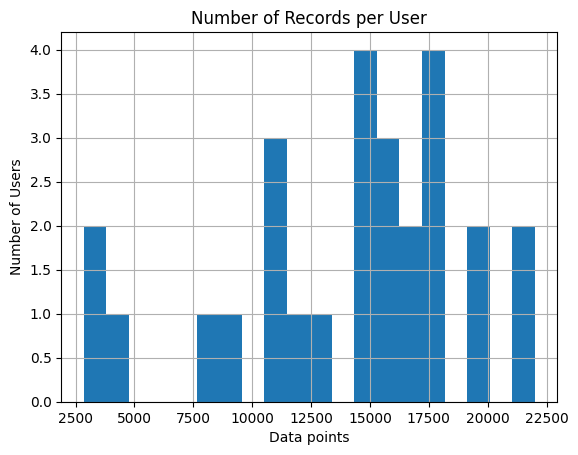

In [24]:
# Total number of users
num_users = data['id'].nunique()
print("Number of unique users:", num_users)

# Number of records per user (days per user)
records_per_user = df.groupby('id').size()
print(records_per_user)

print("Average records per user:", records_per_user.mean())
print("Min records per user:", records_per_user.min())
print("Max records per user:", records_per_user.max())

records_per_user.hist(bins=20)
plt.title("Number of Records per User")
plt.xlabel("Data points")
plt.ylabel("Number of Users")
plt.show()



In [25]:
# Shape
print("Number of records (rows):", data.shape[0])
print("Number of attributes (columns):", data.shape[1])

# Missing values
missing = data.isnull().sum()
missing_percent = 100 * data.isnull().mean()
missing_table = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

print(missing_table)


Number of records (rows): 1973
Number of attributes (columns): 21
                      Missing Count  Missing %
variable                                      
appCat.weather                 1860  94.272681
appCat.game                    1780  90.217942
appCat.finance                 1766  89.508363
appCat.unknown                 1709  86.619361
appCat.office                  1697  86.011151
appCat.travel                  1544  78.256462
appCat.utilities               1540  78.053725
sms                            1239  62.797770
appCat.entertainment           1123  56.918398
appCat.social                   985  49.923974
appCat.other                    853  43.233654
appCat.communication            790  40.040547
activity                        785  39.787126
appCat.builtin                  778  39.432337
screen                          766  38.824126
circumplex.valence              707  35.833756
circumplex.arousal              705  35.732387
mood                            705  35.7

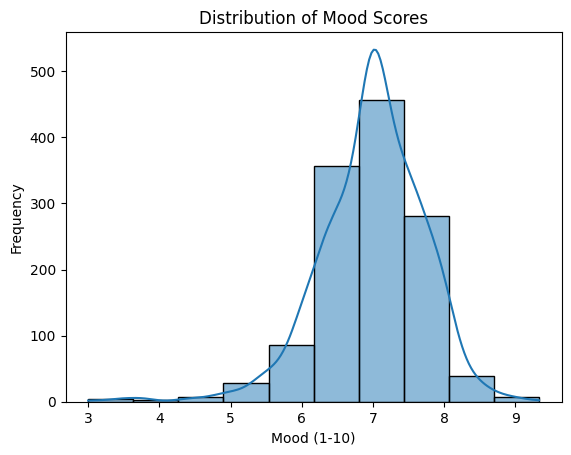

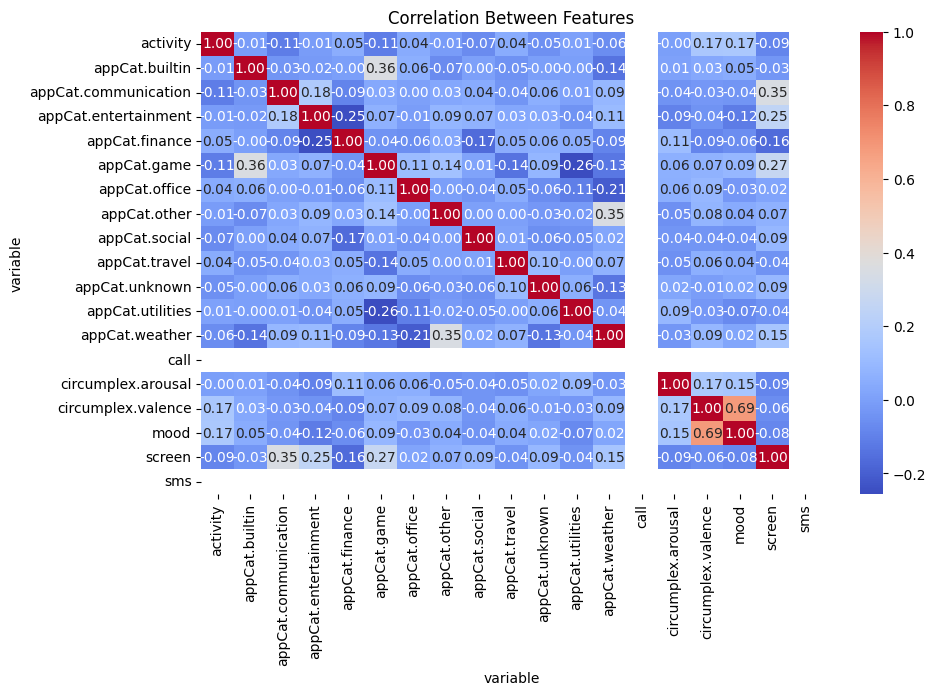

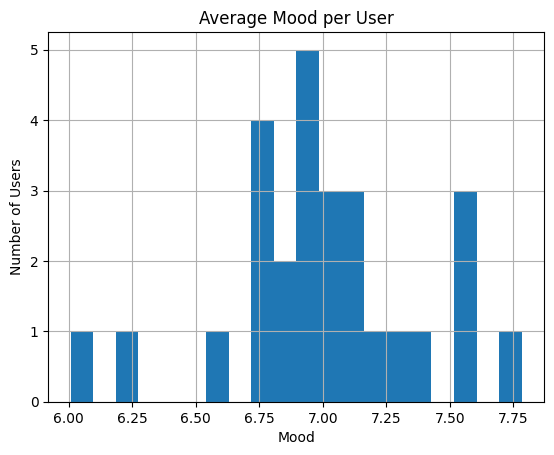

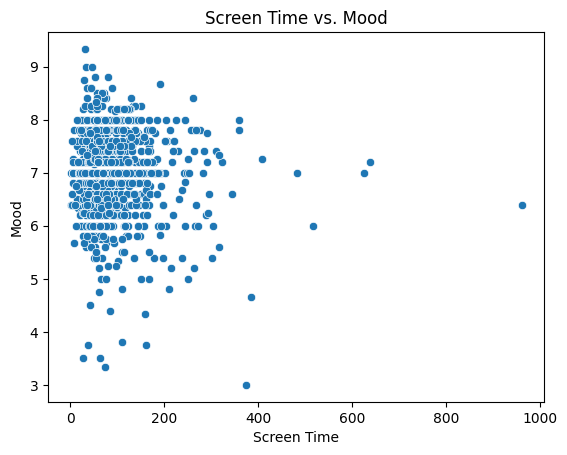

In [26]:
# Distribution of mood scores
sns.histplot(data['mood'].dropna(), bins=10, kde=True)
plt.title("Distribution of Mood Scores")
plt.xlabel("Mood (1-10)")
plt.ylabel("Frequency")
plt.show()

# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Features")
plt.show()

# Average mood per user
mood_per_user = data.groupby("id")["mood"].mean()
mood_per_user.hist(bins=20)
plt.title("Average Mood per User")
plt.xlabel("Mood")
plt.ylabel("Number of Users")
plt.show()

# Relationship between screen time and mood
sns.scatterplot(x='screen', y='mood', data=data)
plt.title("Screen Time vs. Mood")
plt.xlabel("Screen Time")
plt.ylabel("Mood")
plt.show()

In [27]:
# Impute Variables Based on Strategy
# Define lists of variables
mood_vars = ['mood', 'circumplex.valence', 'circumplex.arousal']
interpolate_vars = ['screen', 'activity']
fill_zero_vars = [col for col in data.columns if col.startswith('appCat.')]
forward_fill_vars = ['call', 'sms']  # Irregular, but meaningful

# Apply imputation per user (grouped)
def impute_group(group):
   # group = group.drop(columns='id')  # Drop grouping column to avoid future warning
    group = group.sort_values('date')

    # Forward fill for mood-related
    group[mood_vars] = group[mood_vars].ffill()

    # Linear interpolation for continuous behavior
    group[interpolate_vars] = group[interpolate_vars].interpolate(method='linear', limit_direction='both')

    # Forward fill for call/sms (irregular but meaningful)
    group[forward_fill_vars] = group[forward_fill_vars].ffill()

    return group


# Group by user and apply imputation
imputed_data = (
    data.groupby('id', group_keys=False)
        .apply(lambda group: impute_group(group))
        .reset_index(drop=True)
)

# Fill app category usage (missing → 0)
imputed_data[fill_zero_vars] = imputed_data[fill_zero_vars].fillna(0)

# Drop rows where mood or next_day_mood are still missing after imputation
imputed_data = imputed_data.dropna(subset=['mood'])

missing_summary = imputed_data.isna().sum()
print("Missing Values After Imputation:")
print(missing_summary[missing_summary > 0])

print(imputed_data.head())

Missing Values After Imputation:
Series([], dtype: int64)
variable       id        date  activity  appCat.builtin  appCat.communication  \
7         AS14.01  2014-02-26  0.081548             0.0                   0.0   
8         AS14.01  2014-02-27  0.081548             0.0                   0.0   
9         AS14.01  2014-02-28  0.081548             0.0                   0.0   
10        AS14.01  2014-03-01  0.081548             0.0                   0.0   
11        AS14.01  2014-03-03  0.081548             0.0                   0.0   

variable  appCat.entertainment  appCat.finance  appCat.game  appCat.office  \
7                          0.0             0.0          0.0            0.0   
8                          0.0             0.0          0.0            0.0   
9                          0.0             0.0          0.0            0.0   
10                         0.0             0.0          0.0            0.0   
11                         0.0             0.0          0.0      

C:\Users\vasso\AppData\Local\Temp\ipykernel_24528\1125561356.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: impute_group(group))


In [ ]:
# Sort by patient and date
imputed_data = imputed_data.sort_values(by=['id', 'date'])

# App category columns (except for other and unknown)
appcat_cols = [col for col in imputed_data.columns if col.startswith("appCat.") and col not in ["appCat.other", "appCat.unknown"]]

# Other features
window_size = 5
rows = []

for patient_id, group in imputed_data.groupby('id'):
    group = group.sort_values('date').reset_index(drop=True)
    
    for i in range(window_size, len(group)):
        window = group.iloc[i - window_size:i]
        target_row = group.iloc[i]
        
        row_data = {
            'id': patient_id,
            'date': target_row['date'],
            'mood': target_row['mood'] 
        }
        
        # 5-day average of activity
        row_data['activity_avg'] = window['activity'].mean()

        # 5-day average for each app category
        for col in appcat_cols:
            row_data[f'{col}_avg'] = window[col].mean()
            
            # Boolean: used app from this category at least once in 5 days
            row_data[f'{col}_used'] = int((window[col] > 0).any())

        # Merge 'other' and 'unknown' app usage into a new category
        if "appCat.other" in window.columns and "appCat.unknown" in window.columns:
           merged_usage = window['appCat.other'] + window['appCat.unknown']
           row_data['appCat.merged_other_unknown_avg'] = merged_usage.mean()
           row_data['appCat.merged_other_unknown_used'] = int((merged_usage > 0).any())

        # 5-day max screen time
        row_data['screen_max'] = window['screen'].max()

        # 5-day sum of sms + call
        row_data['sms_call_sum'] = window['sms'].sum() + window['call'].sum()

        # 5-day average of circumplex.arousal, valence, and mood
        row_data['arousal_avg'] = window['circumplex.arousal'].mean()
        row_data['valence_avg'] = window['circumplex.valence'].mean()
        row_data['mood_avg'] = window['mood'].mean()

        rows.append(row_data)

# Final instance-based dataset
final_dataset = pd.DataFrame(rows)

print(final_dataset.head())

        id        date      mood  activity_avg  appCat.builtin_avg  \
0  AS14.01  2014-03-05  6.333333      0.081548                 0.0   
1  AS14.01  2014-03-06  6.333333      0.081548                 0.0   
2  AS14.01  2014-03-07  6.333333      0.081548                 0.0   
3  AS14.01  2014-03-10  6.333333      0.081548                 0.0   
4  AS14.01  2014-03-11  6.333333      0.081548                 0.0   

   appCat.communication_avg  appCat.entertainment_avg  appCat.finance_avg  \
0                       0.0                       0.0                 0.0   
1                       0.0                       0.0                 0.0   
2                       0.0                       0.0                 0.0   
3                       0.0                       0.0                 0.0   
4                       0.0                       0.0                 0.0   

   appCat.game_avg  appCat.office_avg  ...  appCat.social_avg  \
0              0.0                0.0  ...         